<a href="https://colab.research.google.com/github/lux21298/IS3/blob/main/ISY503_Nguyen_Bui_M2_Programming_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [ ]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [ ]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [ ]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [ ]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
161,0,91,toyota,gas,std,four,hatchback,fwd,front,95.70,...,98,2bbl,3.19,3.03,9.00,70,4800,28,34,8358
182,2,122,volkswagen,diesel,std,two,sedan,fwd,front,97.30,...,97,idi,3.01,3.40,23.00,52,4800,37,46,7775
190,3,256,volkswagen,gas,std,two,hatchback,fwd,front,94.50,...,109,mpfi,3.19,3.40,8.50,90,5500,24,29,9980


In [ ]:
#@title Hide
'''LABEL = 'price'

numeric_feature_names = car_data[['symboling','normalized-losses','wheel-base','engine-size','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']]
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

#The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10'''

"LABEL = 'price'\n\nnumeric_feature_names = car_data[['symboling','normalized-losses','wheel-base','engine-size','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']]\ncategorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))\n\n#The correct solution will pass these assert statements.\nassert len(numeric_feature_names) == 15\nassert len(categorical_feature_names) == 10"

In [ ]:
LABEL = 'price'
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [ ]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
177,-1,65,102.40,175.60,66.50,53.90,2458,122,92,4200,27,32,3.31,3.54,8.70
15,0,?,103.50,189.00,66.90,55.70,3230,209,182,5400,16,22,3.62,3.39,8.00
5,2,?,99.80,177.30,66.30,53.10,2507,136,110,5500,19,25,3.19,3.40,8.50
162,0,91,95.70,166.30,64.40,52.80,2140,98,70,4800,28,34,3.19,3.03,9.00
161,0,91,95.70,166.30,64.40,52.80,2122,98,70,4800,28,34,3.19,3.03,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2,137,86.60,144.60,63.90,50.80,1713,92,58,4800,49,54,2.91,3.41,9.60
56,3,150,95.30,169.00,65.70,49.60,2380,70,101,6000,17,23,?,?,9.40
35,0,110,96.50,163.40,64.00,54.50,2010,92,76,6000,30,34,2.91,3.41,9.20
100,0,106,97.20,173.40,65.20,54.70,2302,120,97,5200,27,34,3.33,3.47,8.50


In [ ]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,num-doors,num-cylinders,body-style,make,drive-wheels,fuel-type,engine-type,engine-location,aspiration,fuel-system
177,four,four,hatchback,toyota,fwd,gas,ohc,front,std,mpfi
15,four,six,sedan,bmw,rwd,gas,ohc,front,std,mpfi
5,two,five,sedan,audi,fwd,gas,ohc,front,std,mpfi
162,four,four,sedan,toyota,fwd,gas,ohc,front,std,2bbl
161,four,four,hatchback,toyota,fwd,gas,ohc,front,std,2bbl
...,...,...,...,...,...,...,...,...,...,...
30,two,four,hatchback,honda,fwd,gas,ohc,front,std,1bbl
56,two,two,hatchback,mazda,rwd,gas,rotor,front,std,4bbl
35,four,four,sedan,honda,fwd,gas,ohc,front,std,1bbl
100,four,four,sedan,nissan,fwd,gas,ohc,front,std,2bbl


In [ ]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [ ]:
#@title Sample
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

'''batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)'''



"batch_size = 16\n\nprint(numeric_feature_names)\nx_df = car_data[numeric_feature_names]\ny_series = car_data['price']\n\n# Create input_fn's so that the estimator knows how to read in your data.\ntrain_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    num_epochs=None,\n    shuffle=True)\n\neval_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    shuffle=False)\n\npredict_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    batch_size=batch_size,\n    shuffle=False)\n\n# Feature columns allow the model to parse the data, perform common\n# preprocessing, and automatically generate an input layer for the tf.Estimator.\nmodel_feature_columns = [\n    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names\n]\nprint('model_feature_columns', model_feature_columns)\n\nest = tf.estimator.DNNRegressor(\n    feature_columns=model_f

In [ ]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

'''batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)'''



"batch_size = 16\n\nprint(numeric_feature_names)\nx_df = car_data[numeric_feature_names]\ny_series = car_data['price']\n\ntrain_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    num_epochs=None,\n    shuffle=True)\n\neval_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    shuffle=False)\n\npredict_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    batch_size=batch_size,\n    shuffle=False)\n\n# Feature columns allow the model to parse the data, perform common\n# preprocessing, and automatically generate an input layer for the tf.Estimator.\nmodel_feature_columns = [\n    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names\n]\nprint('model_feature_columns', model_feature_columns)\n\nest = tf.estimator.DNNRegressor(\n    feature_columns=model_feature_columns,\n    hidden_units=[64],\n    optimizer=tf.train.AdagradOpti

In [ ]:
#@title Setting
# Install necessary packages
!pip install tensorflow==2.12.0
!pip install tensorflow-estimator==2.12.*
!pip install scikit-learn

# TensorFlow setup
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# TensorFlow Estimator components
from tensorflow_estimator.python.estimator.canned import dnn
from tensorflow_estimator.python.estimator.inputs import pandas_io

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn tools
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
#@title Task 1: Make your best model with numeric features. No normalization allowed.

# Set batch size
batch_size = 16

# Print numeric feature names
print(numeric_feature_names)

# Prepare input features and target variable
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Define input functions for training, evaluation, and prediction
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Create numeric feature columns for the estimator
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

# Build the DNNRegressor with 2 hidden layers and Adam optimizer
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[128, 64],
    optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    activation_fn=tf.nn.relu
)

# Train model in steps and evaluate performance
num_print_statements = 10
num_training_steps = 20000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)

    # Make predictions on evaluation data
    predictions = list(est.predict(eval_input_fn))
    predicted_values = [p['predictions'][0] for p in predictions]

    # Calculate RMSE and R-squared
    mse = mean_squared_error(y_series, predicted_values)
    rmse = mse**0.5
    r2 = r2_score(y_series, predicted_values)

    # Print evaluation scores
    scores = est.evaluate(eval_input_fn)
    print(f"scores: {scores}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']



Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.


model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='peak-rpm', shape=(1,), default_value=None

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


scores: {'average_loss': 17660430.0, 'label/mean': 12949.43, 'loss': 278491400.0, 'prediction/mean': 12025.715, 'global_step': 2000}, RMSE: 4202.4312, R-squared: 0.7281


Instructions for updating:
Use standard file utilities to get mtimes.


scores: {'average_loss': 16678080.0, 'label/mean': 12949.43, 'loss': 263000500.0, 'prediction/mean': 11810.279, 'global_step': 4000}, RMSE: 4083.8806, R-squared: 0.7432
scores: {'average_loss': 11912547.0, 'label/mean': 12949.43, 'loss': 187851700.0, 'prediction/mean': 13647.824, 'global_step': 6000}, RMSE: 3451.4559, R-squared: 0.8166
scores: {'average_loss': 6998876.0, 'label/mean': 12949.43, 'loss': 110366890.0, 'prediction/mean': 13304.359, 'global_step': 8000}, RMSE: 2645.5388, R-squared: 0.8922


Instructions for updating:
Use standard file APIs to delete files with this prefix.


scores: {'average_loss': 8255797.5, 'label/mean': 12949.43, 'loss': 130187576.0, 'prediction/mean': 11683.689, 'global_step': 10000}, RMSE: 2873.2905, R-squared: 0.8729
scores: {'average_loss': 5405776.0, 'label/mean': 12949.43, 'loss': 85244930.0, 'prediction/mean': 12499.989, 'global_step': 12000}, RMSE: 2325.0325, R-squared: 0.9168
scores: {'average_loss': 4634007.5, 'label/mean': 12949.43, 'loss': 73074740.0, 'prediction/mean': 13458.024, 'global_step': 14000}, RMSE: 2152.6745, R-squared: 0.9287
scores: {'average_loss': 5436330.5, 'label/mean': 12949.43, 'loss': 85726750.0, 'prediction/mean': 12333.514, 'global_step': 16000}, RMSE: 2331.5940, R-squared: 0.9163
scores: {'average_loss': 3905252.8, 'label/mean': 12949.43, 'loss': 61582830.0, 'prediction/mean': 12595.354, 'global_step': 18000}, RMSE: 1976.1714, R-squared: 0.9399
scores: {'average_loss': 2671986.0, 'label/mean': 12949.43, 'loss': 42135164.0, 'prediction/mean': 13072.293, 'global_step': 20000}, RMSE: 1634.6210, R-squared

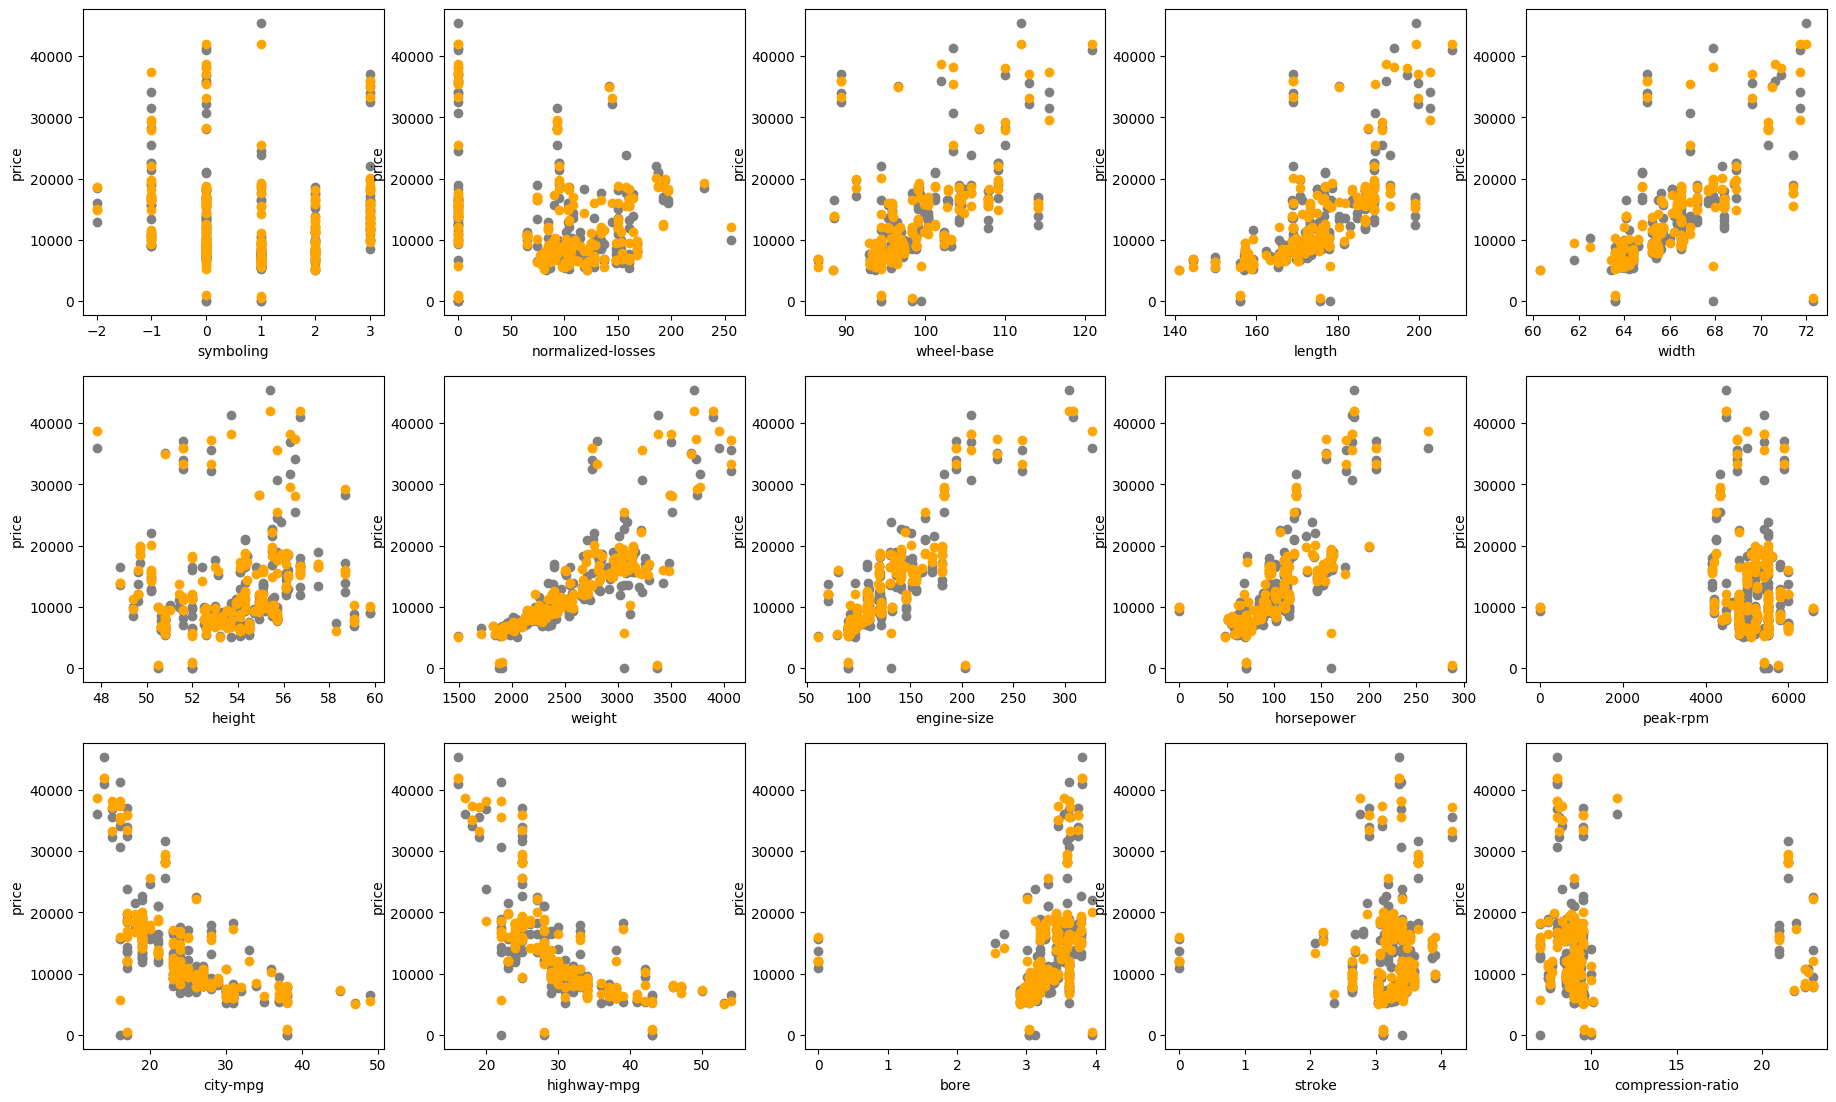

In [ ]:
#@title Matplotlib 1
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]

  num_cols = 5
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    row = i // num_cols
    col = i % num_cols
    axis = axarr[row, col]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

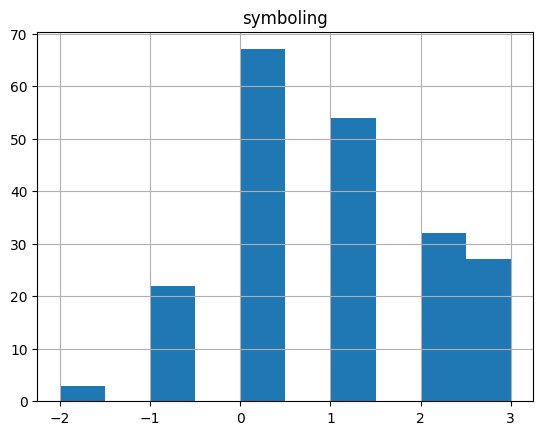

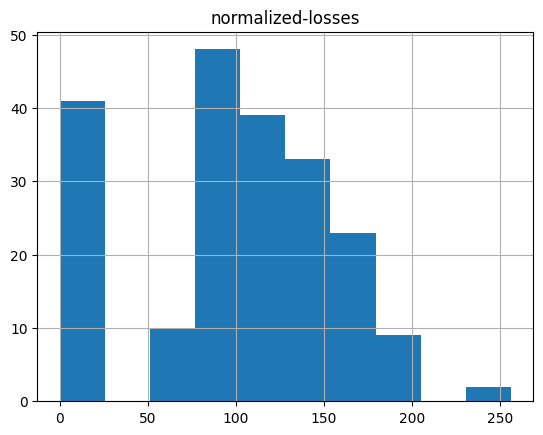

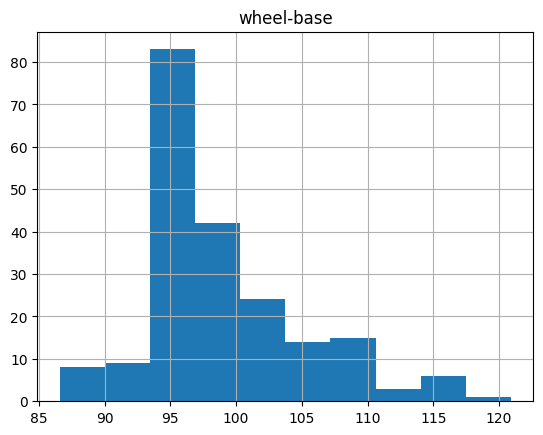

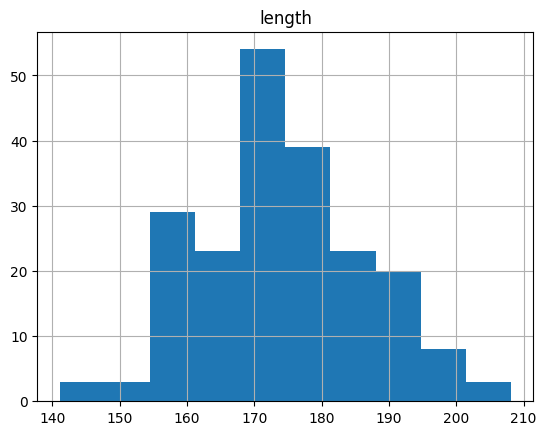

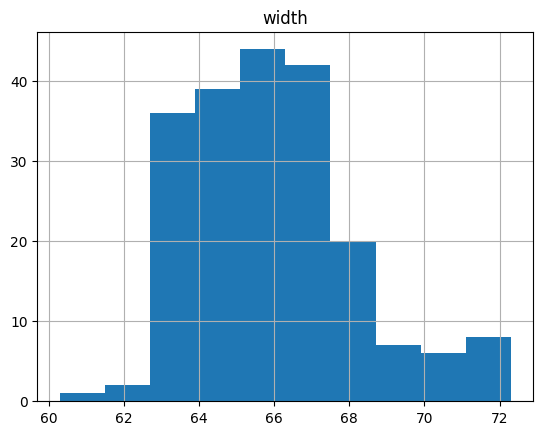

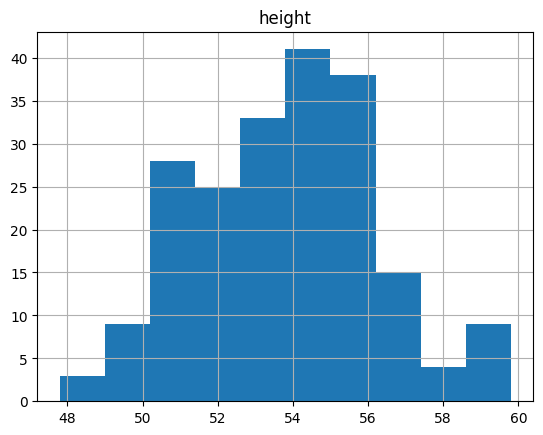

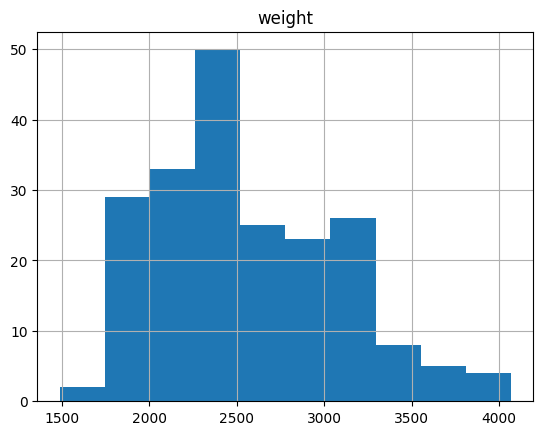

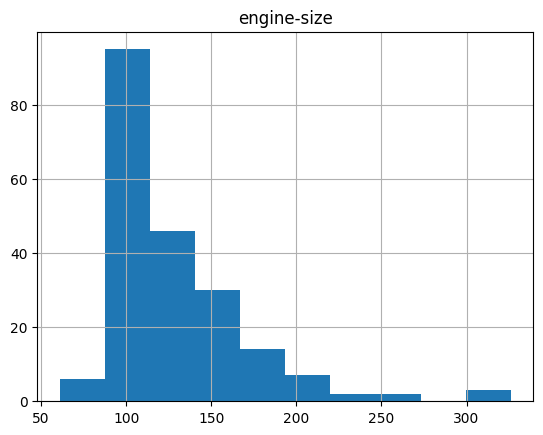

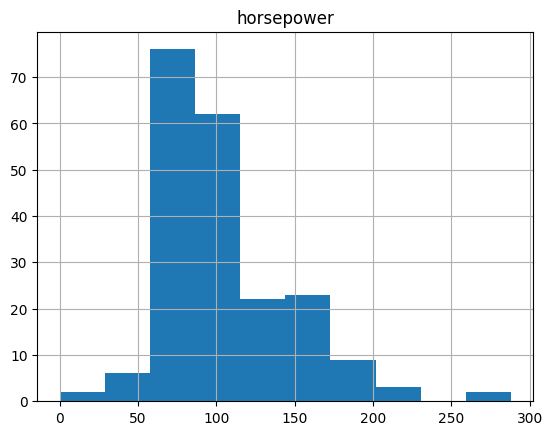

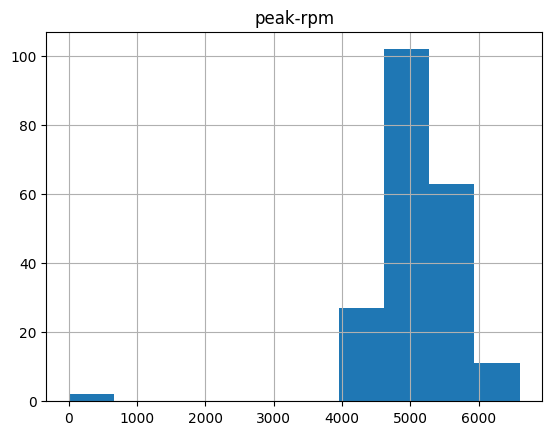

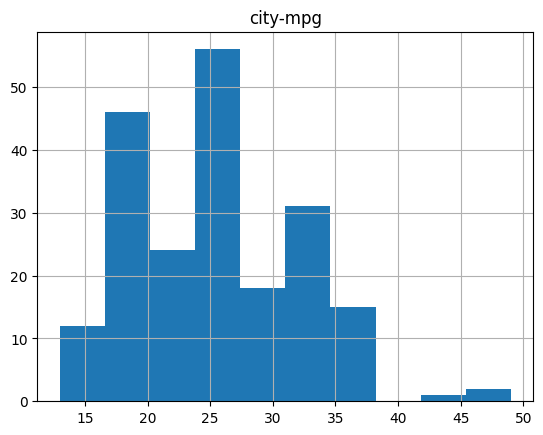

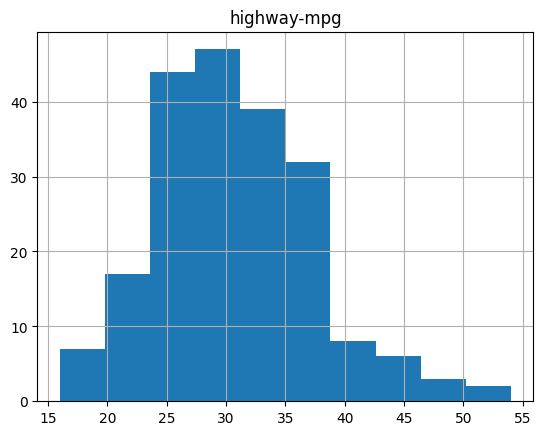

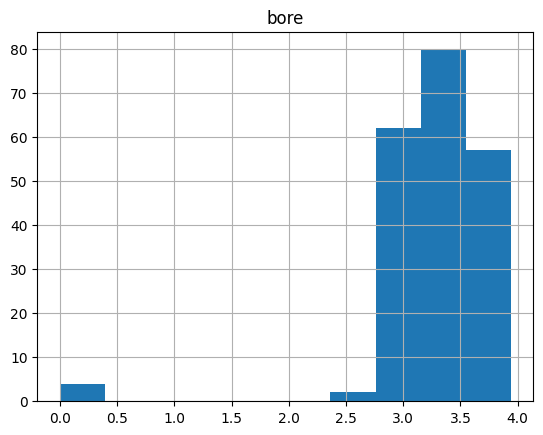

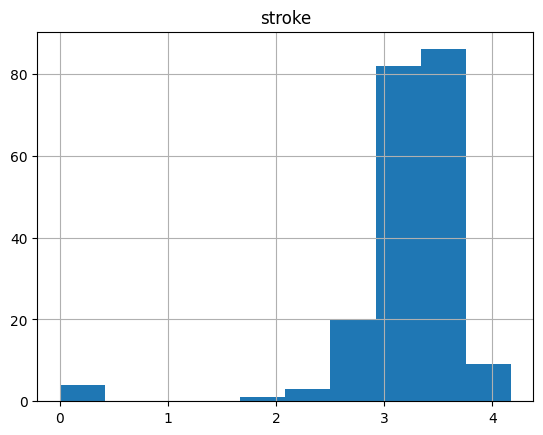

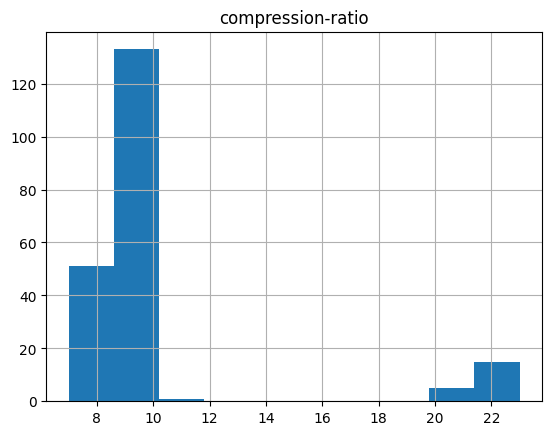

In [ ]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [ ]:
#@title Task 2: Add normalization to numeric features using different techniques
# Set batch size
batch_size = 16

# Print numeric feature names
print(numeric_feature_names)

# Prepare input features and target
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Prevent division by zero
epsilon = 1e-6

# Compute basic statistics for normalization
mean = x_df.mean()
std = x_df.std()
min_val = x_df.min()
max_val = x_df.max()
median = x_df.median()

# Initialize feature columns
model_feature_columns = []

# Z-score normalization for selected features
z_score_features = ['width', 'height', 'weight', 'length', 'highway-mpg']
for feature in z_score_features:
    model_feature_columns.append(
        tf.feature_column.numeric_column(
            feature,
            normalizer_fn=lambda x, f=feature: (x - mean[f]) / (std[f] + epsilon)
        )
    )

# Min-max normalization
min_max_features = ['symboling', 'wheel-base']
for feature in min_max_features:
    model_feature_columns.append(
        tf.feature_column.numeric_column(
            feature,
            normalizer_fn=lambda x, f=feature: (x - min_val[f]) / (max_val[f] - min_val[f] + epsilon)
        )
    )

# Robust scaling using median and IQR
robust_features = ['city-mpg', 'stroke', 'normalized-losses', 'engine-size', 'horsepower']
iqr = x_df.quantile(0.75) - x_df.quantile(0.25)
for feature in robust_features:
    model_feature_columns.append(
        tf.feature_column.numeric_column(
            feature,
            normalizer_fn=lambda x, f=feature: (x - median[f]) / (iqr[f] + epsilon)
        )
    )

# Log transformation for skewed features
log_features = ['peak-rpm', 'compression-ratio']
for feature in log_features:
    model_feature_columns.append(
        tf.feature_column.numeric_column(
            feature,
            normalizer_fn=lambda x: tf.math.log(x + epsilon)
        )
    )

# Define input functions for training, evaluation, and prediction
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Override with default numeric columns (already normalized data)
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name)
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

# Build DNNRegressor with 3 hidden layers
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[128,64,32],
    optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    activation_fn=tf.nn.relu
)

# Train and evaluate the model in steps
num_print_statements = 10
num_training_steps = 30000

for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)

    # Make predictions
    predictions = list(est.predict(eval_input_fn))
    predicted_values = [p['predictions'][0] for p in predictions]

    # Compute performance metrics
    mse = mean_squared_error(y_series, predicted_values)
    rmse = mse**0.5
    r2 = r2_score(y_series, predicted_values)

    # Print loss and evaluation metrics
    result = est.evaluate(eval_input_fn)
    print(f"Step {_ + 1} - Loss: {result['average_loss']:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")


['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

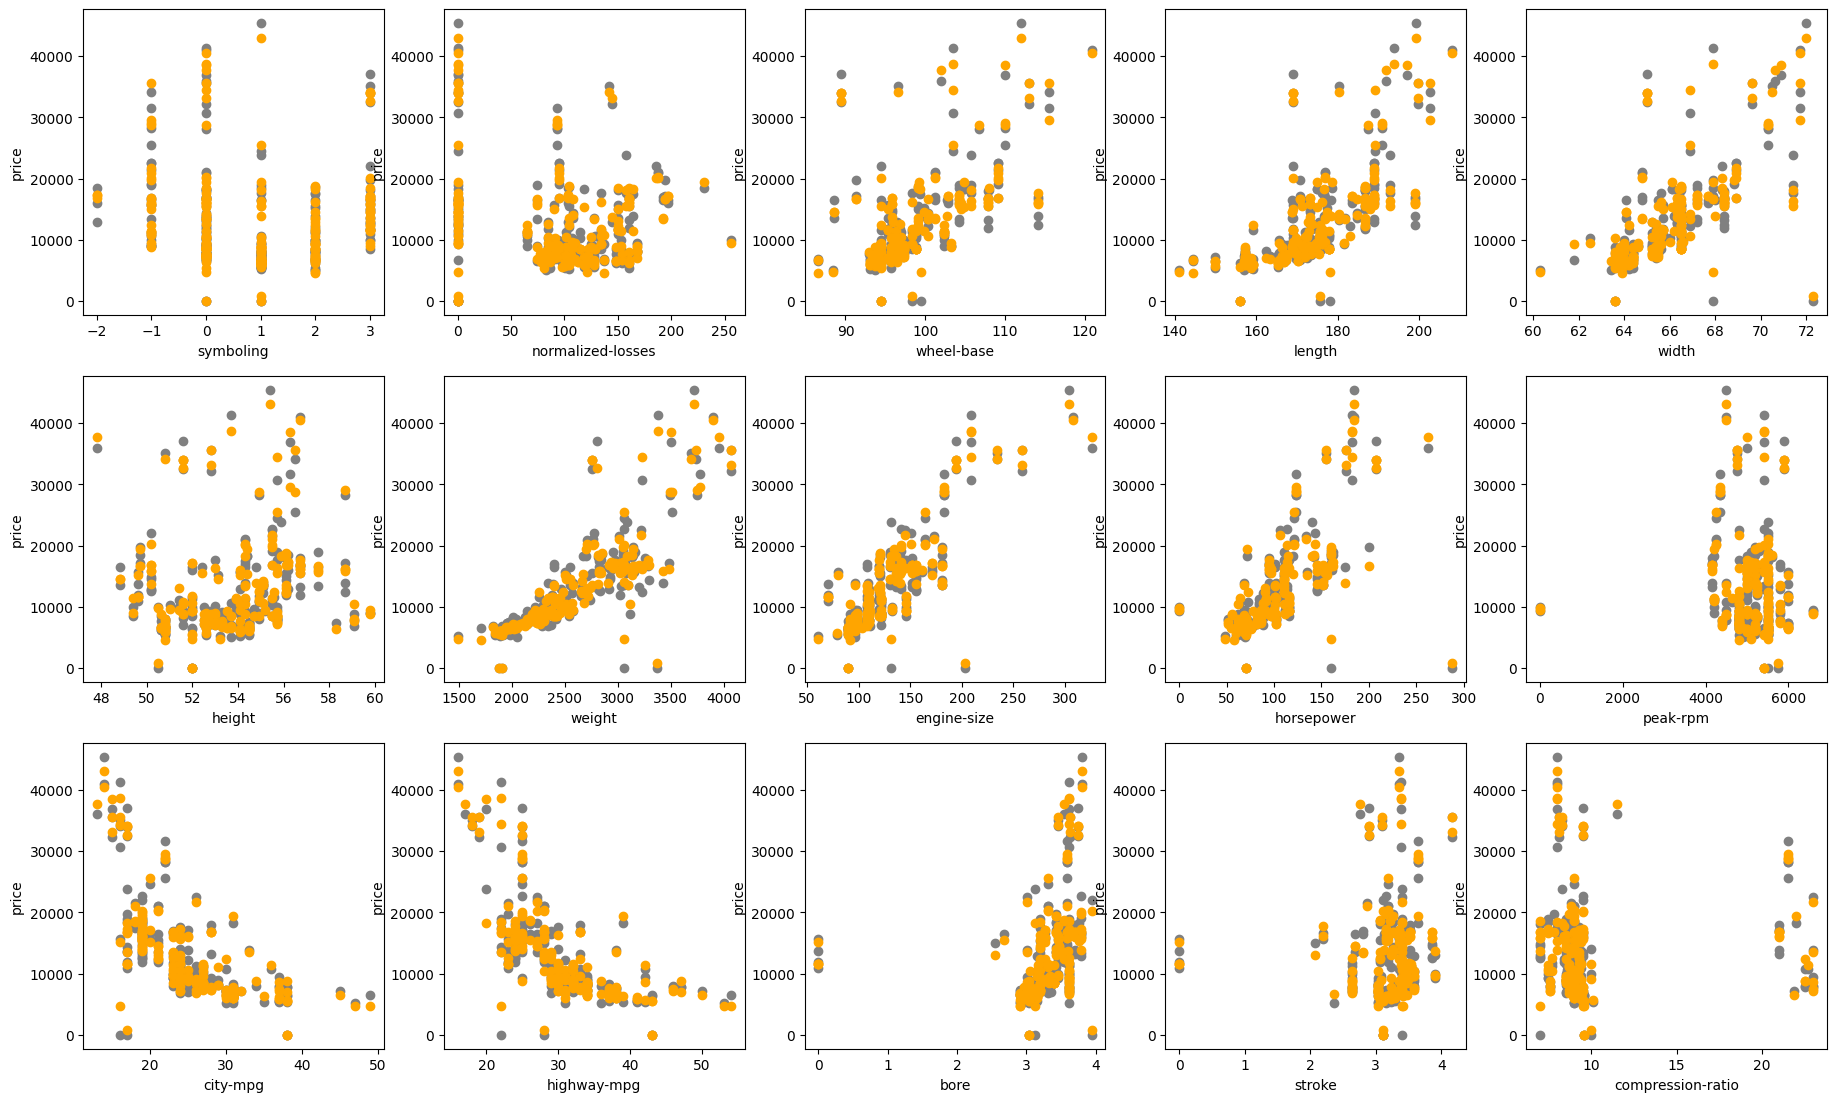

In [ ]:
#@title Matplotlib 2
from matplotlib import pyplot as plt

def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]

  num_cols = 5
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [ ]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

'''batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)'''

"batch_size = 16\n\nprint(numeric_feature_names)\nx_df = car_data[numeric_feature_names]\ny_series = car_data['price']\n\ntrain_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    num_epochs=None,\n    shuffle=True)\n\neval_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    shuffle=False)\n\npredict_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    batch_size=batch_size,\n    shuffle=False)\n\n# Epsilon prevents divide by zero.\nepsilon = 0.000001\nmodel_feature_columns = [\n    tf.feature_column.numeric_column(feature_name,\n                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))\n    for feature_name in numeric_feature_names\n]\nprint('model_feature_columns', model_feature_columns)\n\nest = tf.estimator.DNNRegressor(\n    feature_columns=model_feature_columns,\n    hidden

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [ ]:
#@title Task 3: Make best model using only categorical features
# --- Set batch size ---
batch_size = 16

# --- Define input features and target using only categorical features ---
x_df = car_data[categorical_feature_names]
y_series = car_data['price']

# --- Input functions for Estimator ---
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

# --- Define categorical feature columns with one-hot encoding (indicator_column) ---
categorical_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name,
            vocabulary_list=car_data[feature_name].unique()
        )
    )
    for feature_name in categorical_feature_names
]

# --- Build DNN Regressor Model using categorical features only ---
est = tf.estimator.DNNRegressor(
    feature_columns=categorical_feature_columns,
    hidden_units=[128, 64],  # Two hidden layers
    optimizer=tf.train.AdamOptimizer(learning_rate=0.005),  # Adam optimizer
    activation_fn=tf.nn.relu  # ReLU activation
)

# --- Training and Evaluation ---
num_print_statements = 10
num_training_steps = 20000

for _ in range(num_print_statements):
    # Train the model for a portion of the total steps
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)

    # Make predictions on evaluation data
    predictions = list(est.predict(eval_input_fn))
    predicted_values = [p['predictions'][0] for p in predictions]

    # Calculate evaluation metrics
    mse = mean_squared_error(y_series, predicted_values)
    rmse = mse**0.5
    r2 = r2_score(y_series, predicted_values)

    # Print loss and metrics
    scores = est.evaluate(eval_input_fn)
    print(f"scores: {scores}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


scores: {'average_loss': 5993870.5, 'label/mean': 12949.43, 'loss': 94518730.0, 'prediction/mean': 13335.949, 'global_step': 2000}, RMSE: 2448.2382, R-squared: 0.9077
scores: {'average_loss': 4361718.0, 'label/mean': 12949.43, 'loss': 68780936.0, 'prediction/mean': 12659.93, 'global_step': 4000}, RMSE: 2088.4726, R-squared: 0.9328
scores: {'average_loss': 3715881.8, 'label/mean': 12949.43, 'loss': 58596600.0, 'prediction/mean': 12667.303, 'global_step': 6000}, RMSE: 1927.6623, R-squared: 0.9428
scores: {'average_loss': 3234199.5, 'label/mean': 12949.43, 'loss': 51000836.0, 'prediction/mean': 12866.412, 'global_step': 8000}, RMSE: 1798.3880, R-squared: 0.9502
scores: {'average_loss': 3082067.0, 'label/mean': 12949.43, 'loss': 48601828.0, 'prediction/mean': 12912.455, 'global_step': 10000}, RMSE: 1755.5817, R-squared: 0.9525
scores: {'average_loss': 3054739.8, 'label/mean': 12949.43, 'loss': 48170896.0, 'prediction/mean': 12909.075, 'global_step': 12000}, RMSE: 1747.7813, R-squared: 0.95

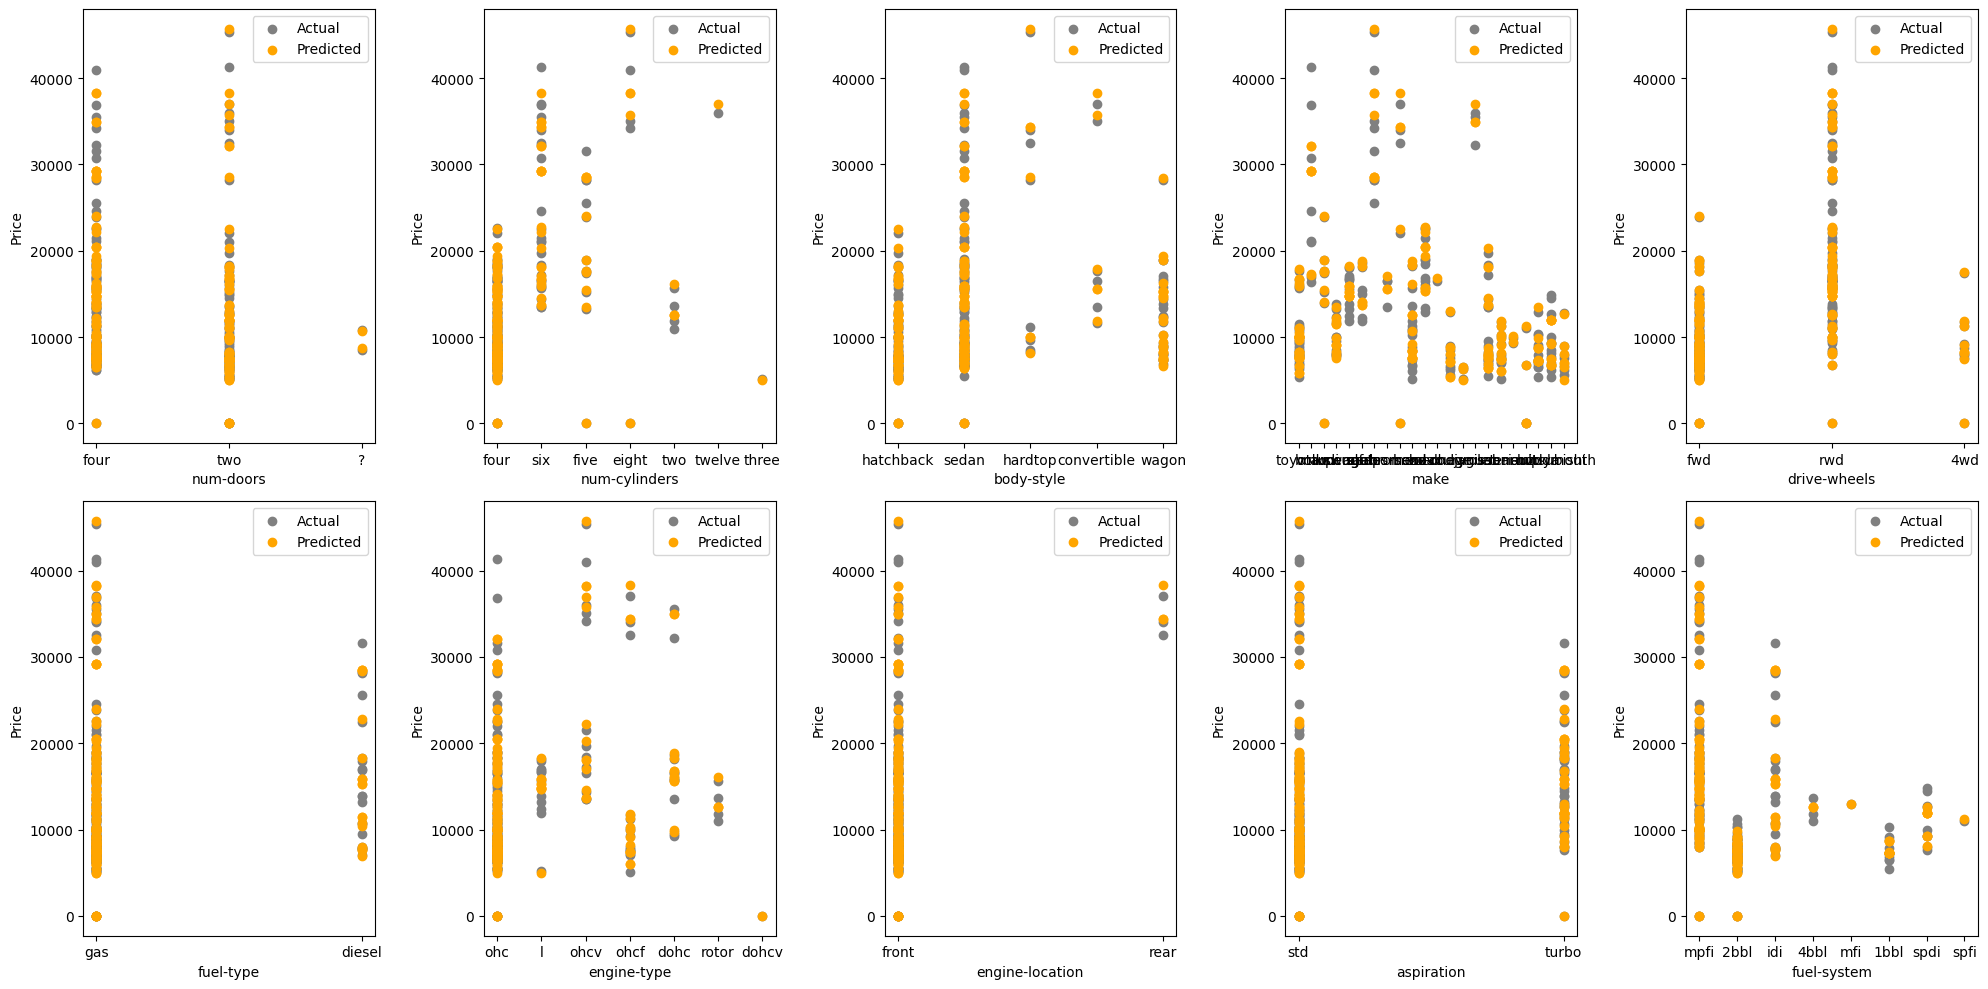

In [ ]:
#@title Matplotlib 3
import matplotlib.pyplot as plt
import math
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def visualize_categorical_predictions(est, car_data, categorical_feature_names, batch_size=16):
    """
    Visualizes the predictions of the categorical features model using Matplotlib.

    Args:
        est: The trained TensorFlow Estimator.
        car_data: The Pandas DataFrame containing the car data.
        categorical_feature_names: A list of categorical feature names.
        batch_size: Batch size for prediction.

    Returns:
        None (Displays the plot)
    """

    x_df = car_data[categorical_feature_names]
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=x_df, batch_size=batch_size, shuffle=False
    )

    predictions = [x["predictions"][0] for x in est.predict(predict_input_fn)]

    num_cols = 5
    num_rows = int(math.ceil(len(categorical_feature_names) / float(num_cols)))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

    for i, feature_name in enumerate(categorical_feature_names):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        # Scatter plot for actual vs. predicted prices for the current feature
        ax.scatter(car_data[feature_name], car_data['price'], c='grey', label='Actual')
        ax.scatter(car_data[feature_name], predictions, c='orange', label='Predicted')

        # Set labels and legend
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Price')
        ax.legend()

    plt.tight_layout()
    plt.show()

# are defined, call the function like this:
visualize_categorical_predictions(est, car_data, categorical_feature_names)

In [ ]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

'''batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)'''



"batch_size = 16\n\nx_df = car_data[categorical_feature_names]\ny_series = car_data['price']\n\ntrain_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    num_epochs=None,\n    shuffle=True)\n\neval_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    shuffle=False)\n\npredict_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    batch_size=batch_size,\n    shuffle=False)\n\nmodel_feature_columns = [\n    tf.feature_column.indicator_column(\n        tf.feature_column.categorical_column_with_vocabulary_list(\n            feature_name, vocabulary_list=car_data[feature_name].unique()))\n    for feature_name in categorical_feature_names\n]\nprint('model_feature_columns', model_feature_columns)\n\nest = tf.estimator.DNNRegressor(\n    feature_columns=model_feature_columns,\n    hidden_units=[64],\n    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),\n  )\n\

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [ ]:
## Your code goes here

In [ ]:
#@title Task 4: Using all the features, make the best model that you can make
batch_size = 16

# Prepare data
x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

# Pre-calculate stats
epsilon = 1e-6  # small value to prevent division by zero
mean = car_data[numeric_feature_names].mean()
std = car_data[numeric_feature_names].std()
min_val = car_data[numeric_feature_names].min()
max_val = car_data[numeric_feature_names].max()
median = car_data[numeric_feature_names].median()
iqr = car_data[numeric_feature_names].quantile(0.75) - car_data[numeric_feature_names].quantile(0.25)

# --- Numeric Feature Columns ---
numeric_columns = []

# Z-score normalization
for feature in ['width', 'height', 'weight', 'length', 'highway-mpg']:
    numeric_columns.append(
        tf.feature_column.numeric_column(
            feature, normalizer_fn=lambda x, f=feature: (x - mean[f]) / (std[f] + epsilon)
        )
    )

# Min-Max scaling
for feature in ['symboling', 'wheel-base']:
    numeric_columns.append(
        tf.feature_column.numeric_column(
            feature, normalizer_fn=lambda x, f=feature: (x - min_val[f]) / (max_val[f] - min_val[f] + epsilon)
        )
    )

# Robust scaling
for feature in ['city-mpg', 'stroke', 'normalized-losses', 'engine-size', 'horsepower']:
    numeric_columns.append(
        tf.feature_column.numeric_column(
            feature, normalizer_fn=lambda x, f=feature: (x - median[f]) / (iqr[f] + epsilon)
        )
    )

# Log transformation
for feature in ['peak-rpm', 'compression-ratio']:
    numeric_columns.append(
        tf.feature_column.numeric_column(
            feature, normalizer_fn=lambda x: tf.math.log(x + epsilon)
        )
    )

# --- Categorical Feature Columns ---
categorical_columns = []
for feature in categorical_feature_names:
    vocab = car_data[feature].unique()
    categorical_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(feature, vocab.tolist())
        )
    )

# --- Combine all feature columns ---
combined_feature_columns = numeric_columns + categorical_columns  # combine both types

# --- Input Functions ---
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df, y=y_series, batch_size=batch_size, num_epochs=None, shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df, y=y_series, batch_size=batch_size, shuffle=False)

# --- DNN Regressor Model ---
est = tf.estimator.DNNLinearCombinedRegressor(
    linear_feature_columns=categorical_columns,  # wide part
    dnn_feature_columns=numeric_columns,         # deep part
    dnn_hidden_units=[128, 64, 32],              # DNN layers
    dnn_optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    dnn_activation_fn=tf.nn.relu
)

# --- Train and Evaluate ---
num_steps = 30000
for i in range(15):
    est.train(train_input_fn, steps=num_steps // 15)  # train in intervals

    # Get predictions for evaluation set
    predictions = list(est.predict(eval_input_fn))
    predicted_values = [p['predictions'][0] for p in predictions]

    # Calculate metrics
    mse = mean_squared_error(y_series, predicted_values)
    rmse = mse**0.5  # Root Mean Squared Error
    r2 = r2_score(y_series, predicted_values)  # R-squared score

    # Print metrics along with loss
    result = est.evaluate(eval_input_fn)
    print(f"Step {i+1} - Loss: {result['average_loss']:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}")


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


Step 1 - Loss: 4519830.0000, RMSE: 2125.9891, R-squared: 0.9304
Step 2 - Loss: 912700.8125, RMSE: 955.3537, R-squared: 0.9859
Step 3 - Loss: 579534.5000, RMSE: 761.2716, R-squared: 0.9911
Step 4 - Loss: 545632.3750, RMSE: 738.6693, R-squared: 0.9916
Step 5 - Loss: 504757.2812, RMSE: 710.4627, R-squared: 0.9922
Step 6 - Loss: 761600.8750, RMSE: 872.6974, R-squared: 0.9883
Step 7 - Loss: 374532.2812, RMSE: 611.9904, R-squared: 0.9942
Step 8 - Loss: 380555.5000, RMSE: 616.8919, R-squared: 0.9941
Step 9 - Loss: 316256.5000, RMSE: 562.3669, R-squared: 0.9951
Step 10 - Loss: 390348.0312, RMSE: 624.7784, R-squared: 0.9940
Step 11 - Loss: 387935.5625, RMSE: 622.8448, R-squared: 0.9940
Step 12 - Loss: 405385.9062, RMSE: 636.6992, R-squared: 0.9938
Step 13 - Loss: 243151.5469, RMSE: 493.1040, R-squared: 0.9963
Step 14 - Loss: 278461.0625, RMSE: 527.6941, R-squared: 0.9957
Step 15 - Loss: 656140.0000, RMSE: 810.0247, R-squared: 0.9899


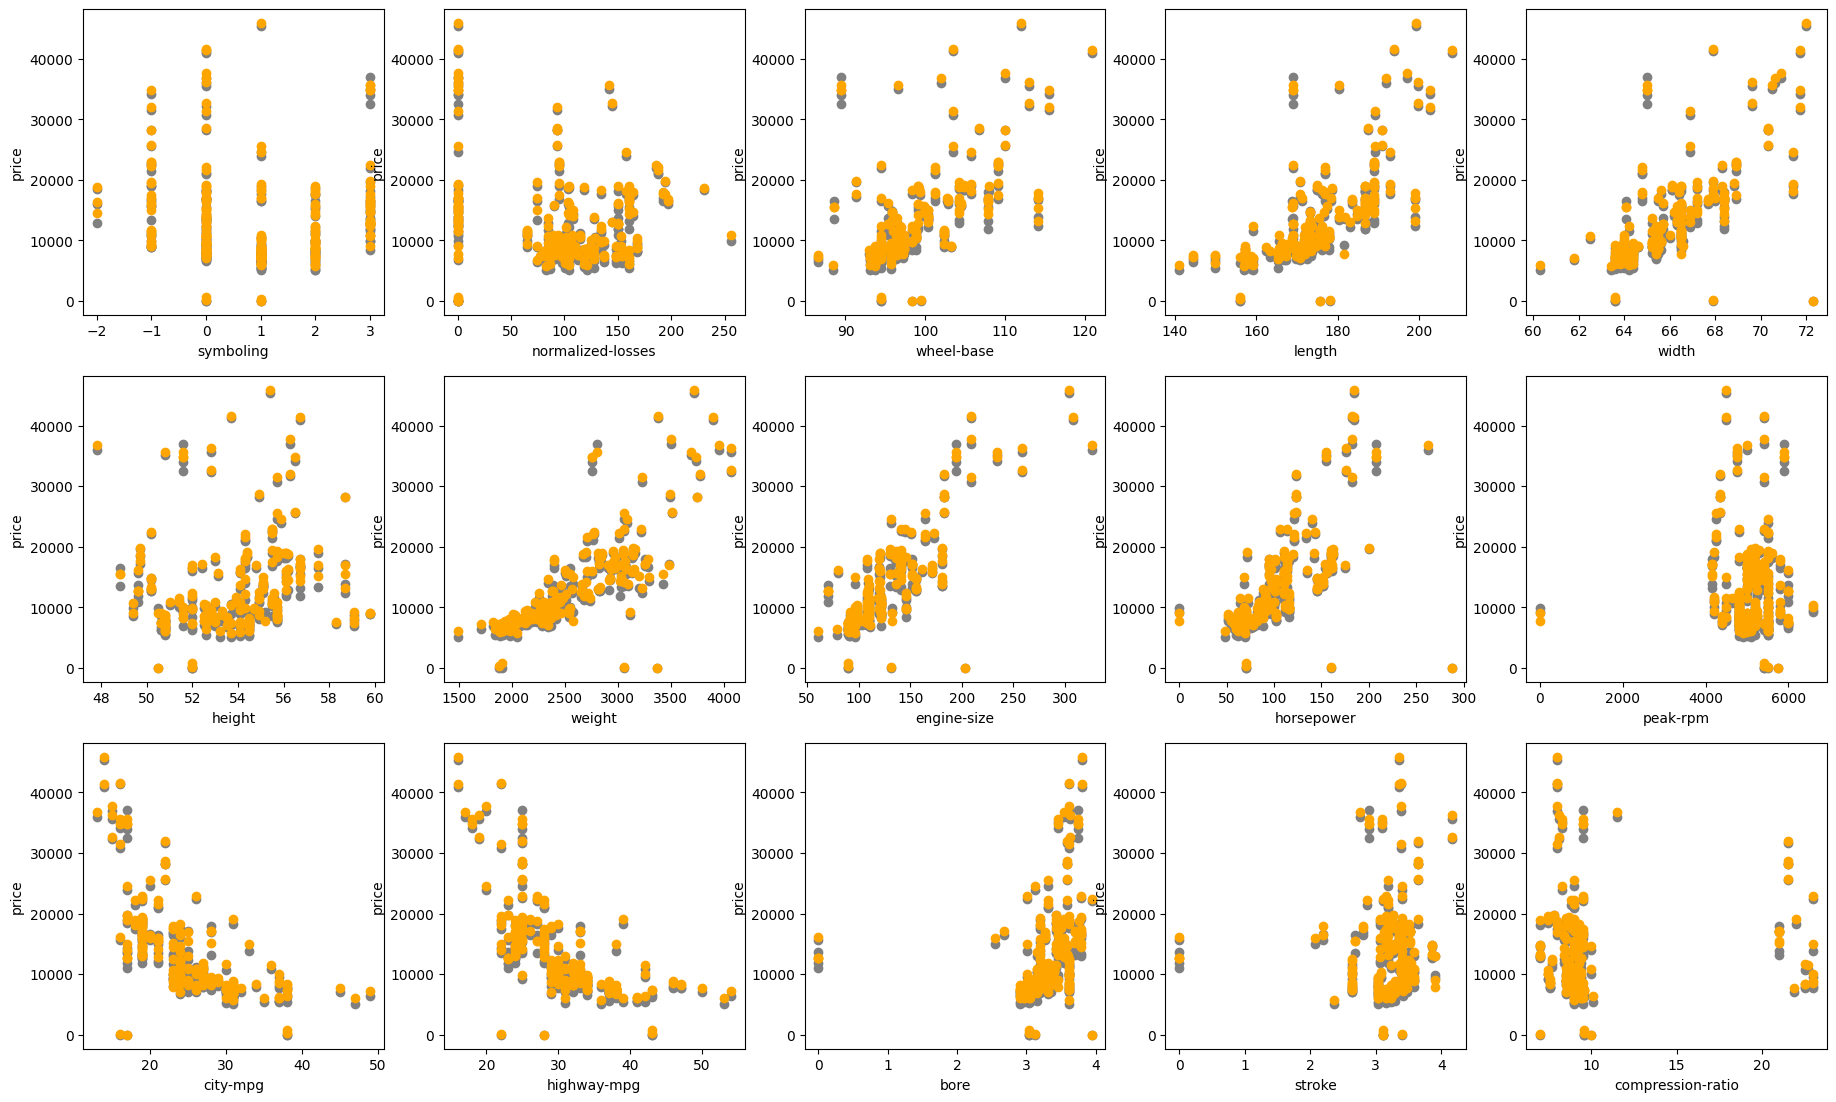

In [ ]:
#@title Matplotlib 4
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]

  num_cols = 5
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [ ]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

'''batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)'''



"batch_size = 16\n\nx_df = car_data[numeric_feature_names + categorical_feature_names]\ny_series = car_data['price']\n\ntrain_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    num_epochs=None,\n    shuffle=True)\n\neval_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    y=y_series,\n    batch_size=batch_size,\n    shuffle=False)\n\npredict_input_fn = tf.estimator.inputs.pandas_input_fn(\n    x=x_df,\n    batch_size=batch_size,\n    shuffle=False)\n\nepsilon = 0.000001\nmodel_feature_columns = [\n    tf.feature_column.indicator_column(\n        tf.feature_column.categorical_column_with_vocabulary_list(\n            feature_name, vocabulary_list=car_data[feature_name].unique()))\n    for feature_name in categorical_feature_names\n] + [\n    tf.feature_column.numeric_column(feature_name,\n                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[featur